# Benchmarking DeLOB

In [2]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import numpy as np
from seqwalk import design
from time import time, sleep
import subprocess
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
lib_size=np.logspace(3, 5, 10, dtype=int)

d = {
    "Candidate space" : [],
    "Preprocessing time" : [],
    "BLAST time" : [],
    "Number of BLAST records" : [],
    "Network elimination time" : [],
    "Total time" : [],
    "Library size" : [],
}

for N in tqdm(lib_size):

    t0 = time()
    
    # generate random seqs
    lib = ["".join(np.random.choice(["A", "C", "G", "T"], size=25)) for _ in range(N)]
    
    # save as FASTA
    seqs = [SeqRecord(Seq(lib[l]), id="seq%d"%l) for l in range(len(lib))]
    SeqIO.write(seqs, "seqs.fasta", "fasta")
    
    t1 = time()
    
    cmd= 'blastn -query seqs.fasta -subject seqs.fasta -outfmt 6 -out res -dust no -word_size 11'
    cmd = cmd.split()    
    subprocess.Popen(cmd).wait()
    
    df = pd.read_csv("res", sep='\t', header=None)
#     # only perfect identity
#     df = df[df[2] == 100]
#     # remove identical
#     df = df[df[3] != 25]
#     # remove high HSP
#     df = df[df[3] < 13]
    
    t2 = time()
    
    trashbin = set()
    keeper = set()
    for row in df.iterrows():
        if row[1][3] < 13 and row[1][3] != 25: 
            query = row[1][0]
            target = row[1][1]
            if query not in keeper:
                if query not in trashbin:
                    keeper.add(query)
                    trashbin.add(target)
            else:
                trashbin.add(target)

    t3 = time()
    
    d["Candidate space"].append(N)
    d["Preprocessing time"].append(t1-t0)
    d["Number of BLAST records"].append(len(df))
    d["BLAST time"].append(t2-t1)
    d["Network elimination time"].append(t3-t2)
    d["Total time"].append(t3-t0)
    d["Library size"].append(len(keeper))

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Total time', ylabel='Library size'>

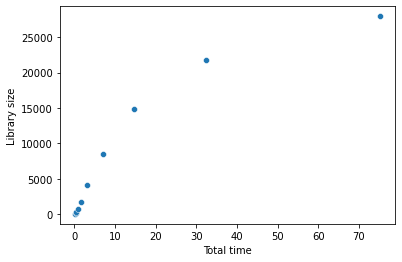

In [3]:
res_df = pd.DataFrame(d)

sns.scatterplot(res_df,
             y="Library size",
             x="Total time")

<AxesSubplot:xlabel='Candidate space', ylabel='Total time'>

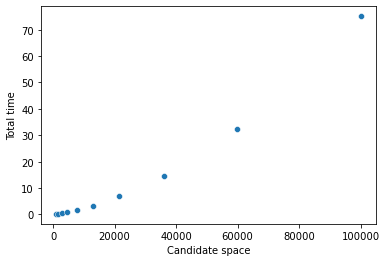

In [4]:
sns.scatterplot(res_df,
             x="Candidate space",
             y="Total time")

In [5]:
res_df.to_csv("DeLOB_benchmarking.csv")

In [4]:
t0 = time()
library = design.max_size(25, 12, alphabet="ACGT", prevented_patterns=[])
t1 = time()

print(t1-t0)

15.3595552444458


In [5]:
sw_time = t1-t0
sw_ls = len(library)
print(sw_ls)

1198372


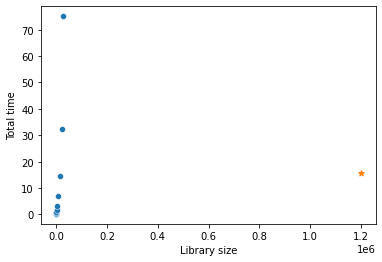

In [8]:
sns.scatterplot(res_df,
             y="Library size",
             y="Total time")
plt.scatter([sw_ls],[sw_time],  marker="*")
# plt.yscale('log')